In [6]:
# choose python 3.8 conda env
# pip install pycaret
from pycaret.regression import *
import pandas as pd
import numpy as np

df = pd.read_csv(r'https://raw.githubusercontent.com/data-to-insight/ERN-sessions/main/data/1980%202023%20average%20house%20prices.csv')
df['Period'] = pd.to_datetime(df['Period'], format='%Y-%m')
df['Month'] = [i.month for i in df['Period']]
df['Year'] = [i.year for i in df['Period']]

df['Series'] = np.arange(1, len(df)+1)
df

,Name,Period,House price index All property types,Average price All property types,Percentage change (monthly) All property types,Percentage change (yearly) All property types,Month,Year,Series
0,United Kingdom,1980-01-01,10.11,19273,3.94,28.59,1,1980,1
1,United Kingdom,1980-02-01,10.11,19273,3.94,28.59,2,1980,2
2,United Kingdom,1980-03-01,10.11,19273,3.94,28.59,3,1980,3
3,United Kingdom,1980-04-01,10.51,20044,4.00,24.15,4,1980,4
4,United Kingdom,1980-05-01,10.51,20044,4.00,24.15,5,1980,5
...,...,...,...,...,...,...,...,...,...
518,United Kingdom,2023-03-01,148.20,282548,-1.00,3.20,3,2023,519
519,United Kingdom,2023-04-01,148.90,283871,0.50,2.50,4,2023,520
520,United Kingdom,2023-05-01,149.50,285053,0.40,1.60,5,2023,521
521,United Kingdom,2023-06-01,151.20,288281,1.10,1.90,6,2023,522


In [7]:
# df.drop(['Name',	
#         #'Period',	
#         'House price index All property types',	
#         'Percentage change (monthly) All property types',	
#         'Percentage change (yearly) All property types'], axis=1, inplace=True)
df = df[['Series','Period',  'Year', 'Month', 'Average price All property types']]
df

,Series,Period,Year,Month,Average price All property types
0,1,1980-01-01,1980,1,19273
1,2,1980-02-01,1980,2,19273
2,3,1980-03-01,1980,3,19273
3,4,1980-04-01,1980,4,20044
4,5,1980-05-01,1980,5,20044
...,...,...,...,...,...
518,519,2023-03-01,2023,3,282548
519,520,2023-04-01,2023,4,283871
520,521,2023-05-01,2023,5,285053
521,522,2023-06-01,2023,6,288281


In [8]:
train = df[(df['Year'] < 2011)]
test = df[df['Year'] >= 2011]

s = setup(data = train, #data to use
          train_size=0.7, # split of test to train data
        #   test_data = test, 
          target = 'Average price All property types', 
          fold_strategy = 'timeseries', 
          date_features = ['Period'],
          ignore_features = ['Year', 'Month', 'Series'],
          #numeric_features = ['Series'], # Sets columns to be interpreted as numberic 
          # (as opposed to ordinal which would be like low, med, high or categorical like yes/no)
          fold = 3, # folds used for cross validation, splits the data multiple times for testing to generalise results
          # transform_target = True, 
          session_id = 123,
          data_split_shuffle=False, # doesn't shuffle rows in train/test split, needed for time series
          fold_shuffle=False # doesn't shuffle folds, again for time series
          )

,Description,Value
0,Session id,123
1,Target,Average price All property types
2,Target type,Regression
3,Original data shape,"(372, 5)"
4,Transformed data shape,"(372, 4)"
5,Transformed train set shape,"(260, 4)"
6,Transformed test set shape,"(112, 4)"
7,Ignore features,3
8,Date features,1
9,Preprocess,True


Once the setup has been successfully executed it shows the information grid containing experiment level information.

Session id: A pseudo-random number distributed as a seed in all functions for later reproducibility. If no session_id is passed, a random number is automatically generated that is distributed to all functions.

Target type: Binary, Multiclass, or Regression. The Target type is automatically detected.

Original data shape: Shape of the original data prior to any transformations.

Transformed train set shape : Shape of transformed train set

Transformed test set shape : Shape of transformed test set

Numeric features : The number of features considered as numerical.

Categorical features : The number of features considered as categorical.

In [9]:
best = compare_models(sort = 'MAE') # mean absolute error

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,10793.0118,172035626.0220,12785.7750,-38.8464,0.2277,0.1881,0.0200
lr,Linear Regression,10807.0833,172344034.3264,12794.8327,-39.2175,0.2277,0.1883,0.8600
lar,Least Angle Regression,10807.0833,172344034.3264,12794.8327,-39.2175,0.2277,0.1883,0.0200
llar,Lasso Least Angle Regression,10807.6251,172361372.9065,12795.3900,-39.2131,0.2278,0.1883,0.0167
lasso,Lasso Regression,10807.6257,172361388.6773,12795.3905,-39.2131,0.2278,0.1883,0.0167
ridge,Ridge Regression,10818.1277,172707276.9949,12806.0593,-39.0788,0.2282,0.1886,0.0200
en,Elastic Net,10837.2286,176818304.5924,12877.0760,-31.0359,0.2368,0.1903,0.0200
omp,Orthogonal Matching Pursuit,10932.0147,175580942.0924,12906.0599,-38.9525,0.2309,0.1909,0.0167
gbr,Gradient Boosting Regressor,12666.9209,314516846.2443,15309.8865,-2.5823,0.2896,0.1983,0.0567
dt,Decision Tree Regressor,12711.2872,316065587.3897,15347.6476,-2.5875,0.2912,0.1995,0.0200


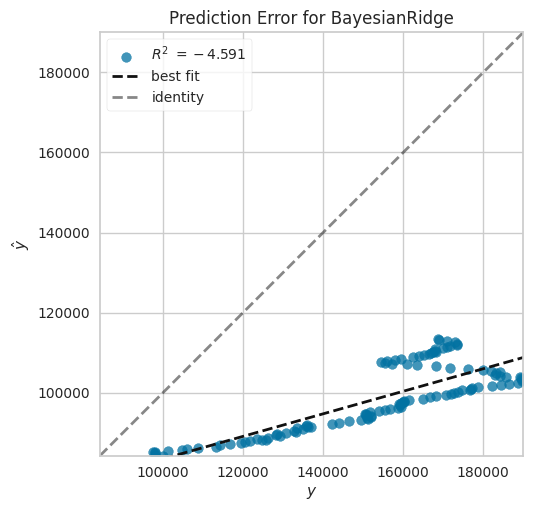

In [10]:
# plot error
plot_model(best, plot = 'error')

In [13]:
future_dates = pd.date_range(start = '2011-01-01', end = '2030-01-01', freq = 'MS')
future_df = pd.DataFrame()
future_df['Period'] = future_dates
future_df['Month'] = [i.month for i in future_dates]
future_df['Year'] = [i.year for i in future_dates]    
max_series = df['Series'][df['Year'] < 2010].max()
future_df['Series'] = np.arange(max_series,(max_series+len(future_dates)))
future_df.head()

,Period,Month,Year,Series
0,2011-01-01,1,2011,360
1,2011-02-01,2,2011,361
2,2011-03-01,3,2011,362
3,2011-04-01,4,2011,363
4,2011-05-01,5,2011,364


In [14]:
predictions_future = predict_model(best, data=future_df)

predictions_future.head()

,Period,Month,Year,Series,prediction_label
0,2011-01-01,1,2011,360,113361.115065
1,2011-02-01,2,2011,361,113652.030361
2,2011-03-01,3,2011,362,113942.945657
3,2011-04-01,4,2011,363,114233.860954
4,2011-05-01,5,2011,364,114524.776250


In [19]:
import plotly.express as px
concat_df = pd.concat([df[df['Year'] < 2011],predictions_future], axis=0)

fig = px.line(concat_df, x=concat_df['Period'], y=["Average price All property types", "prediction_label"], template = 'plotly_dark')
fig.add_scatter(x=df['Period'], y=df['Average price All property types'])

fig.show()

In [18]:
final_real_val = train['Average price All property types'].iloc[-1]
first_predicted_value = predictions_future['prediction_label'].iloc[1]

print(final_real_val)
predictions_future['corrected value'] = predictions_future['prediction_label'] - first_predicted_value + final_real_val

import plotly.express as px
concat_df = pd.concat([df[df['Year'] < 2011],predictions_future], axis=0)

fig = px.line(concat_df, x=concat_df['Period'], y=["Average price All property types", "corrected value"], template = 'plotly_dark')
fig.add_scatter(x=df['Period'], y=df['Average price All property types'])

fig.show()

168703
